In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import paths, utils
import nibabel as nib
from scipy.stats import pearsonr
from nilearn import plotting
import matplotlib.pyplot as plt

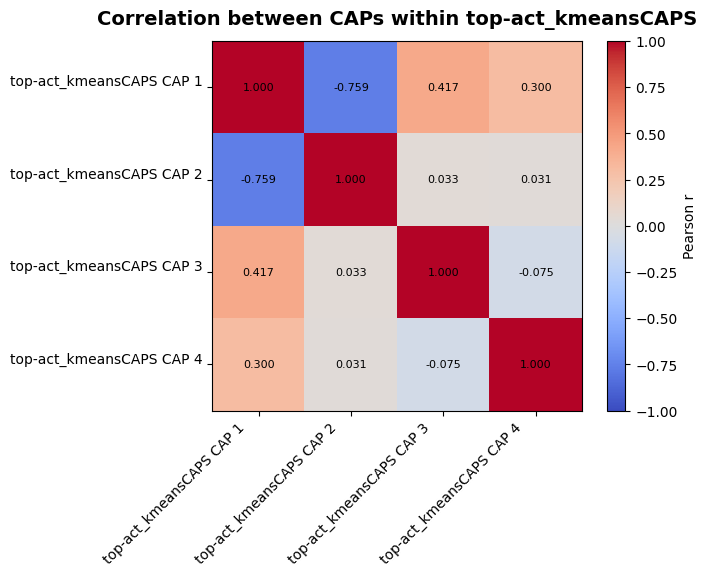

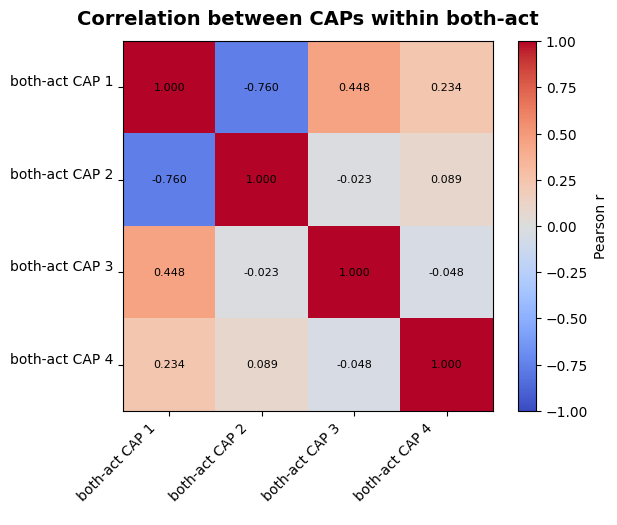

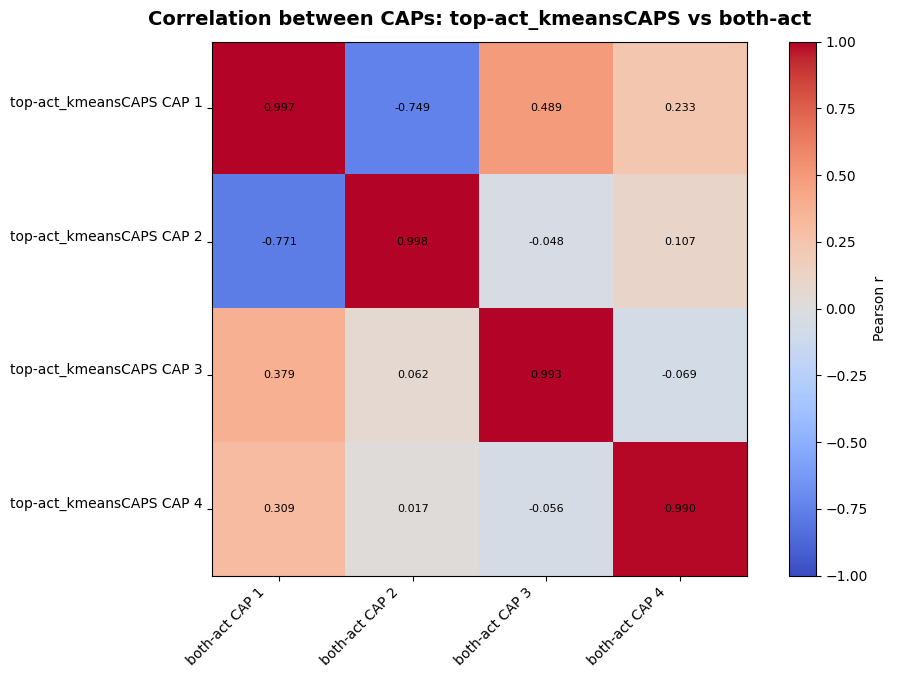

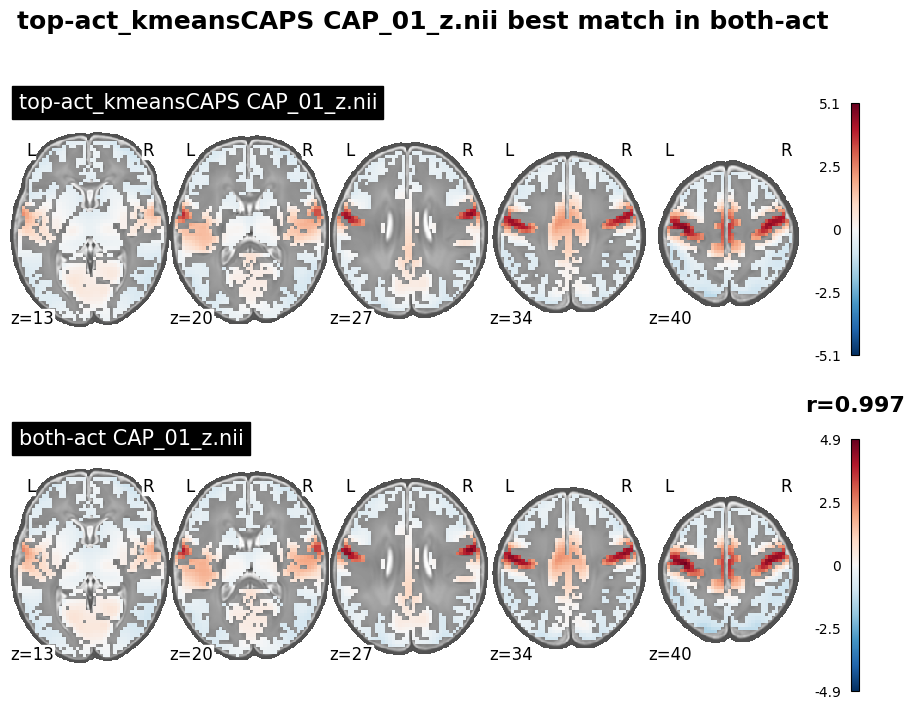

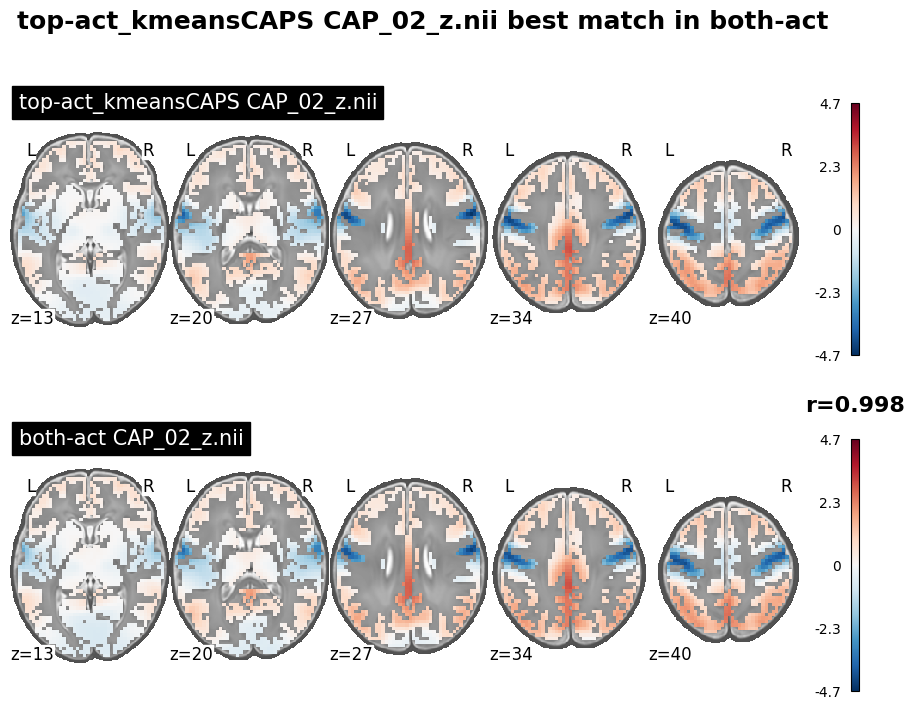

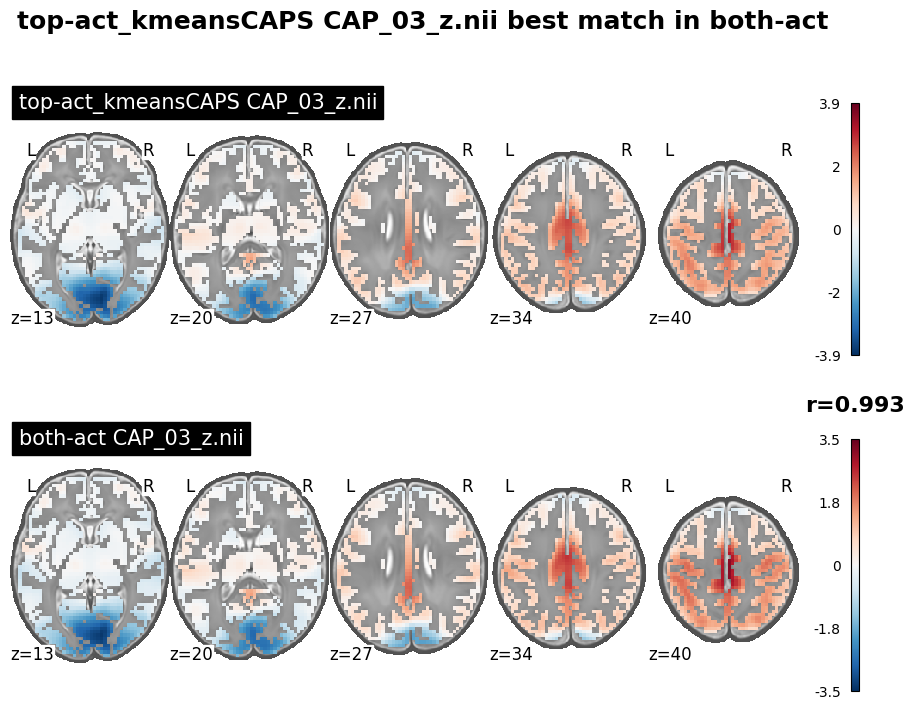

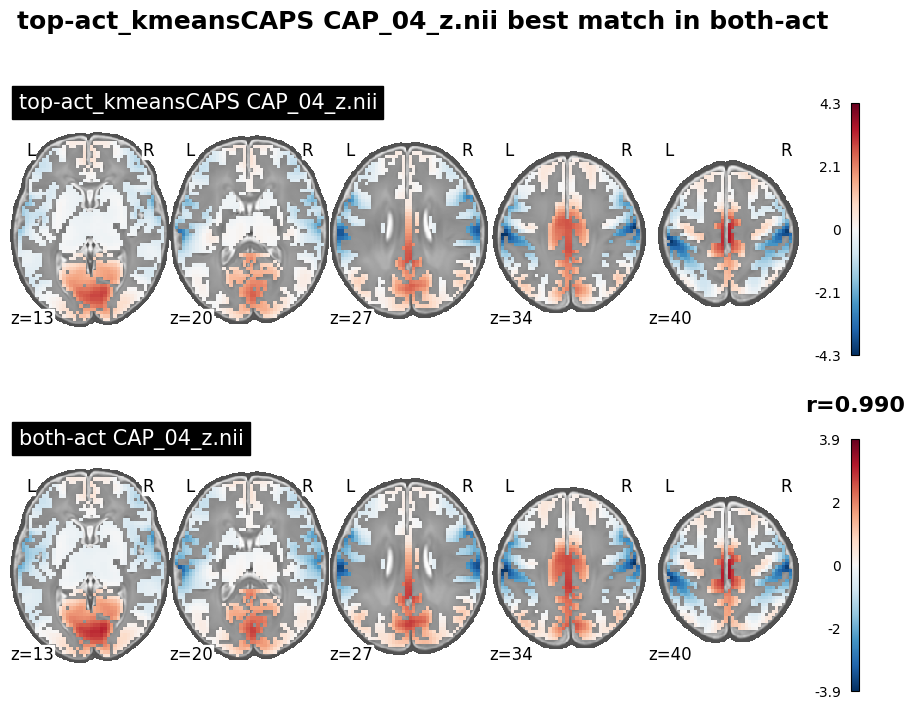

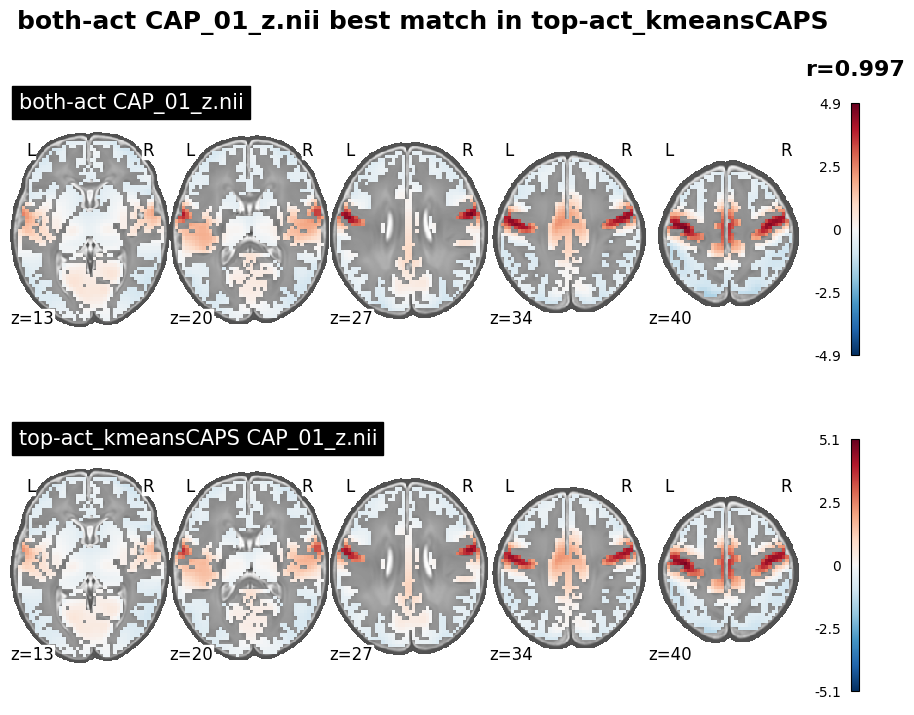

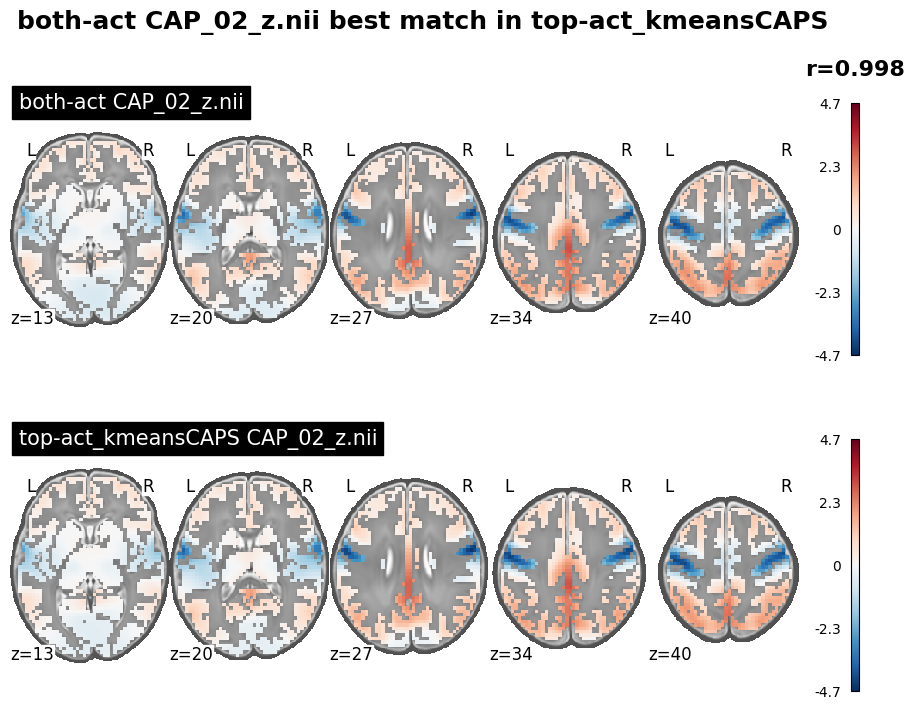

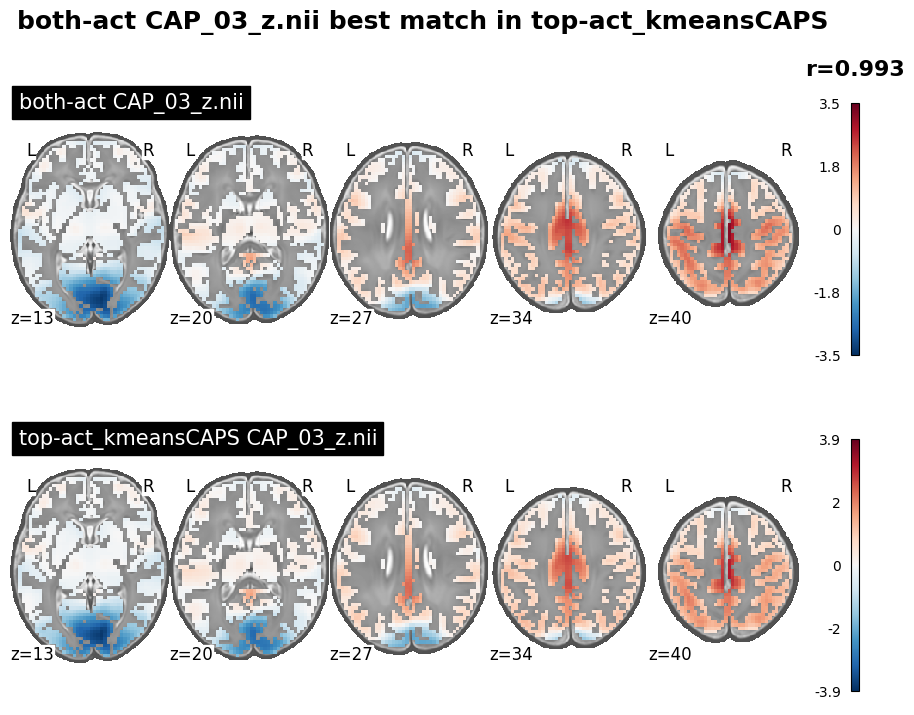

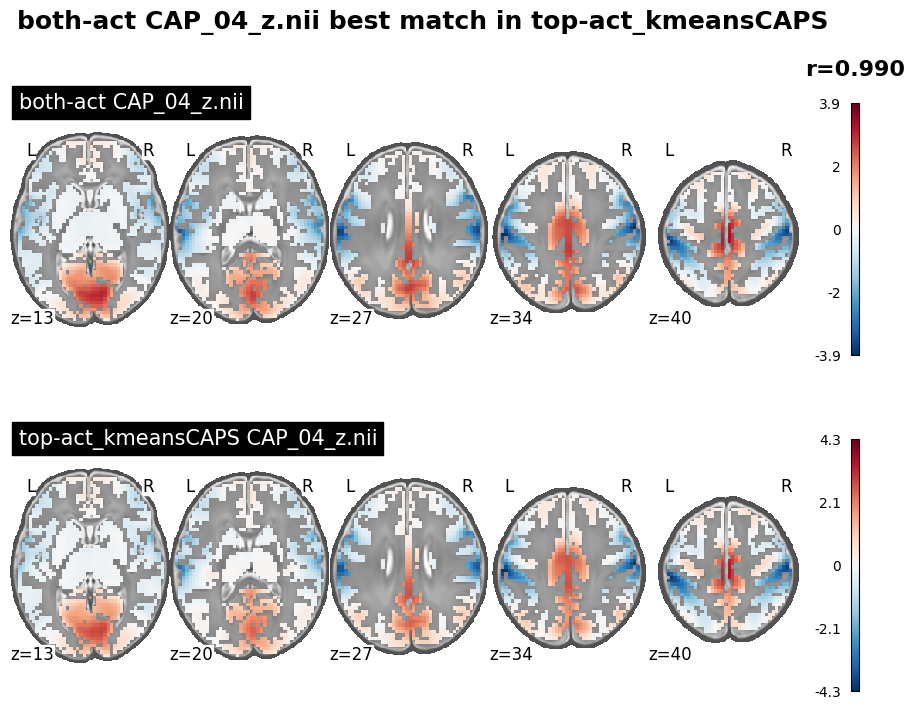

In [3]:
folderA = "vectorizedCorr_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"
folderA_name = "top-act_kmeansCAPS"
folderA_glob = "CAP_*_z.nii"

folderB = "vectorizedCorr_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-both_n-481"
folderB_name = "both-act"
folderB_glob = "CAP_*_z.nii"

utils.compare_folder(
    folderA=folderA,
    folderB=folderB,
    folderA_name=folderA_name,
    folderB_name=folderB_name,
    folderA_glob=folderA_glob,
    folderB_glob=folderB_glob,
)